## Setup

In [74]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
os.chdir('..')
import virl
from matplotlib import pyplot as plt

## Agent Implementation

In [100]:
class QTable:
    def __init__(self, initial, num_of_actions):
        self.q_table = {}
        self.initial = initial
        self.num_of_actions = num_of_actions
    
    def get_actions(self, state):
        state_tuple = tuple(state)
        return self.q_table.get(state_tuple, [self.initial]*self.num_of_actions)
    
    def get_action_value(self, state, action_index):
        state_tuple = tuple(state)
        return self.q_table.get(state_tuple, [self.initial]*self.num_of_actions)[action_index]
    
    def set_action_value(self, state, action_index, action_value):
        if not tuple(state) in self.q_table:
            self.q_table[tuple(state)] = [self.initial]*self.num_of_actions
        self.q_table[tuple(state)][action_index] = action_value 

class QLearningAgent:

    def __init__(self, env):
        self.num_of_actions = env.action_space.n
        self.env = env

        self.q_table = QTable(initial=0, num_of_actions=self.num_of_actions) 
        
        # hyper parameters
        self.discount = 0.99 # gamma
        self.learning_rate = 0.25 # step size, alpha
        self.episodes = 15000
        self.print_out_every_x_episodes = 500
        
        # hyper parameters for epsilon
        self.initial_epsilon = 1 # initial
        self.decrease_factor = 0.00008 # epsilon
        
        # hyper parameters for discretising state data
        self.highest = 600000000
        self.lowest = 0
        self.number_bins = 20
        
        print("Hyperparameter dump")
        print("----")
        print("Number Of Episodes = " + str(self.episodes))
        print("Print out every " + str(self.print_out_every_x_episodes) + " episodes")
        print("Learning Rate = " + str(self.learning_rate))
        print("Discount = " + str(self.discount))
        print("----")
        print("Initial Epsilon = " + str(self.initial_epsilon))
        print("Epsilon Decrease Factor = " + str(self.decrease_factor))
        print("----")
        
    def continous_to_discrete(self,continous_state):
        bins = np.linspace(self.lowest,self.highest,num=self.number_bins)
        discrete = np.digitize(continous_state,bins)
        return discrete
    
    def run_all_episodes(self):
        all_rewards = []
        all_q_table_exploits = []
        epislon = self.initial_epsilon # at the start only explore
        
        for episode in range(1, self.episodes + 1):
            rewards, exploited_q_table = self.run_episode(epislon)
            total_reward = np.sum(rewards)

            if episode % self.print_out_every_x_episodes == 0:
                print("Episode number: " + str(episode) + ". Total reward in episode: " + str(total_reward) + ". Episode executed with epsilon = " + str(epislon))
                print("Average total reward in last " + str(self.print_out_every_x_episodes) + " episodes: " + str(np.mean(all_rewards[-self.print_out_every_x_episodes:])))
                print("Average number of times we exploited q table in last " + str(self.print_out_every_x_episodes) + " episodes: " + str(np.mean(all_q_table_exploits[-self.print_out_every_x_episodes:])))
                print("-----")
            all_rewards.append(total_reward)
            all_q_table_exploits.append(exploited_q_table)
            epislon -= self.decrease_factor #hyperparameter
            
        return all_rewards
    
    def run_episode(self,epislon):
        rewards = []
        done = False
        
        state = self.env.reset()
        state = self.continous_to_discrete(state)
        
        exploited_q_table = 0
        
        while not done:
            random_number = np.random.random()
            if random_number < epislon:
                #explore
                action = np.random.choice(self.num_of_actions)
            else:
                #exploit
                action = self.get_action(state)
                exploited_q_table+=1
                
            new_state, reward, done, i = self.env.step(action=action) # Q-learning
            new_state = self.continous_to_discrete(new_state)
            
            #update q table
            self.update_q_table(state,new_state,action,reward)
            
            rewards.append(reward)
            state = new_state
        return (rewards, exploited_q_table)
    
    def update_q_table(self,state,new_state,action,reward):
        #target
        #max of a' given the 
        max_a_prime = np.max(self.q_table.get_actions(new_state))
        target = reward + (self.discount*max_a_prime)
        
        #compute difference
        action_value = self.q_table.get_action_value(state,action)
        difference = target - action_value
        
        #take a small step in the delta direction
        new_q = action_value + (self.learning_rate * difference)
        
        self.q_table.set_action_value(state,action,new_q)
        
    
    def get_action(self,state):
        #exploit the q table
        actions = self.q_table.get_actions(state)
        action = np.argmax(self.q_table.get_actions(state))
        return action

## Analysis

In [101]:
env = virl.Epidemic(stochastic=False, noisy=False)
agent = QLearningAgent(env)
rewards = agent.run_all_episodes()

Hyperparameter dump
----
Number Of Episodes = 15000
Print out every 500 episodes
Learning Rate = 0.25
Discount = 0.99
----
Initial Epsilon = 1
Epsilon Decrease Factor = 8e-05
----


KeyboardInterrupt: 

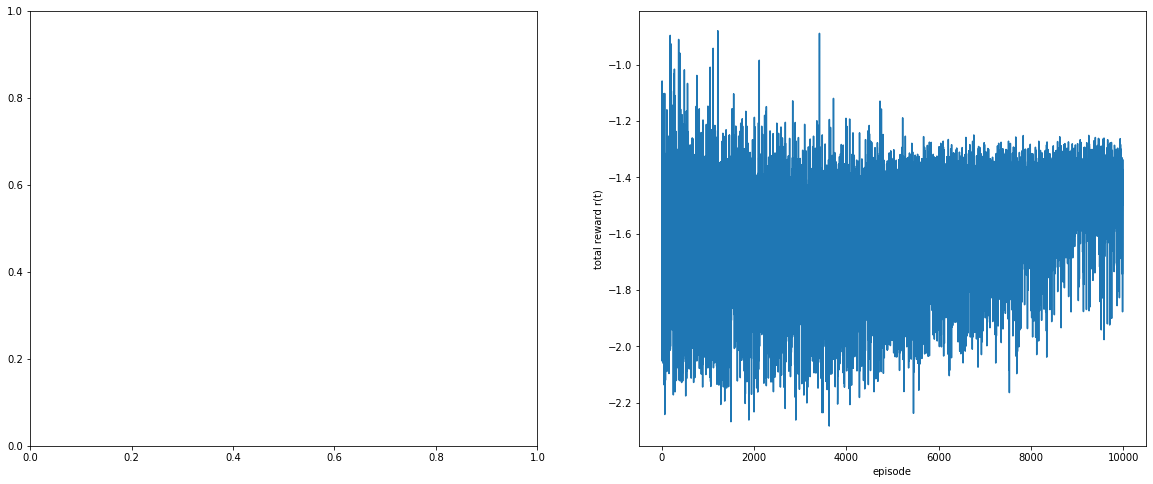

In [99]:
def plot(agent, rewards):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[1].plot(rewards);
    axes[1].set_xlabel('episode')
    axes[1].set_ylabel('total reward r(t)')
    
plot(agent, rewards)

## Evaluation

Eval here